## Tópicos Especiais em Inteligência Artificial
### Classificação de diagnostico de cancer de mama com Deep Neural Network (DNN)
### Instituto Federal de Minas Gerais - IFMG
### Aluno: César Nogueira Rodrigues

Neste trabalho vamos utilizar o dataset Breast Cancer Wisconsin

1. ID do paciente 
2. Espessura (1-10)
3. Uniformidade de tamanho da célula (1-10)
3. Uniformidade de forma da célula (1-10)
5. Adesão marginal (1-10)
6. Tamanho único epitelial da célula (1-10)
7. Quantidade de núcleos nus (1-10)
8. Cromatina (1-10)
9. Quantidade de nucleos normais (1-10)
10. Mitoses (1-10)
11. [SAIDA] Classificação (2 para indicar BENIGNO, 4 Para indicar MALIGNO)

O dataset contém 458 amostras com: 
- 65.5% de casos BENIGNO
- 34.5% de casos MALIGNO 

In [1]:
# função para deixar o jupyter com celulas preenchendo a tela toda

from IPython.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

In [2]:
#importação de bibliotecas 

# exportacao do requiriment.txt
import subprocess
import sys 

#  lib para dados e graficos
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow as tf 
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy


import pydot as pyd
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd


c:\Users\User\.conda\envs\redesneurais\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.11.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
#checagem de GPU
import keras
print('tensorflow: ', tf.__version__)
print('Keras: ', keras.__version__)
print('GPU disponivel: ', len(tf.config.list_physical_devices('GPU')) > 0)
print('GPU(s): ', tf.config.list_physical_devices('GPU'))

tensorflow:  2.20.0
Keras:  3.12.0
GPU disponivel:  False
GPU(s):  []


In [4]:
#rotina para exportacao da lista de pacotes
def exportaRequirements():
    try:
        resultado = subprocess.run([sys.executable, '-m', 'pip', 'freeze'],
                                capture_output = True,
                                text = True,
                                check = True)
        with open('requirements.txt', 'w') as f:
            f.write(resultado.stdout)
        print('Arquivo exportado com sucesso!')
    except subprocess.CalledProcessError as e:
        print(f'Deu erro: {e}')
exportaRequirements()

Arquivo exportado com sucesso!


## 2. Importação do dataset


In [5]:
col_names = ['ID','espessura','tam_celula','forma_celula',
             'adesao','tam_epitelial','nucleos_nus', 'cromatina',
             'nucleos_normais', 'mitoses', 'diagnostico']


# importação do dataset
data = pd.read_csv('dataset/breast-cancer-wisconsin.csv', header=None, names=col_names)

# remove a coluna ID pois ela nao sera usada para nada
data = data.drop('ID', axis=1)

# substitui '?' por NaN
data = data.replace('?', np.nan)

#converte tudo para numero 
data = data.astype(float)

# converte o codigo do diagnostico 
data = data.assign(diagnostico = data['diagnostico'].replace({2:0, 4:1}))

# nomeia as entradas e saidas
x_names = data.columns[:-1].tolist()
y_names = data.columns[-1:].tolist()



In [6]:
data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0
695,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0
696,5.0,10.0,10.0,3.0,7.0,3.0,8.0,10.0,2.0,1.0
697,4.0,8.0,6.0,4.0,3.0,4.0,10.0,6.0,1.0,1.0


## 3. Configuração do Experimento

In [7]:
# realizar interpolação de dados 
interp_exec = True 

# realizar deteccao e substituicao de outliers 
outliers_exec = True

# realizar normalizacao de dados 
normalization_exec = True

# realizar escalonamento de dados 
scale_exec = True

# exportar os datasets tratados 
export_frames = True 

# gerar um modelo ou usar um pronto
new_model = True


## 4. Análise de Dados 

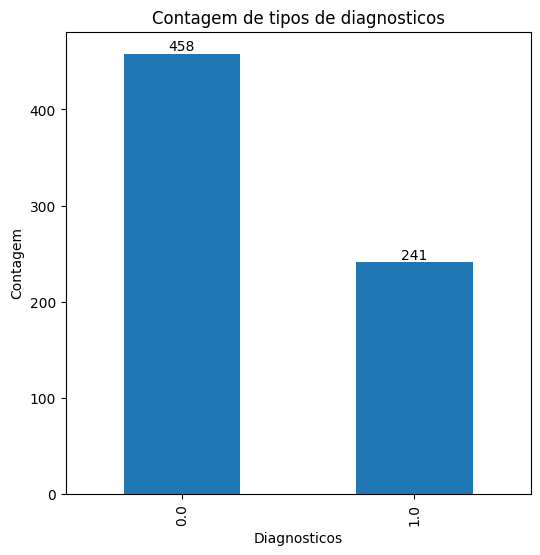

In [8]:
# contagem de diagnosticos 
diag_counts = data['diagnostico'].value_counts()

#plota gafico 

plt.figure(figsize=(6,6))
diag_counts.plot(kind='bar')
plt.xlabel('Diagnosticos')
plt.ylabel('Contagem')
plt.title('Contagem de tipos de diagnosticos')

#adiciona rotulos
for i, count in enumerate(diag_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### 4.1 Sumarização estística

In [9]:
def sumarizacao(data):
    stats = []
    for column in x_names:
        values = data[column]

        maximum = round(values.max(), 2)
        minimum = round(values.min(), 2)
        mean = round(values.mean(), 2)
        median = round(values.median(), 2)
        std = round(values.std(), 2)

        stats.append([column, maximum, minimum, mean, median, std])
    
    headers = ['Coluna','Maximo', 'Minimo', 'Media', 'Mediana', 'Desvio Padrao']

    table = tabulate(stats, headers, tablefmt='grid')
    print(table)

sumarizacao(data)

+-----------------+----------+----------+---------+-----------+-----------------+
| Coluna          |   Maximo |   Minimo |   Media |   Mediana |   Desvio Padrao |
+=================+==========+==========+=========+===========+=================+
| espessura       |       10 |        1 |    4.42 |         4 |            2.82 |
+-----------------+----------+----------+---------+-----------+-----------------+
| tam_celula      |       10 |        1 |    3.13 |         1 |            3.05 |
+-----------------+----------+----------+---------+-----------+-----------------+
| forma_celula    |       10 |        1 |    3.21 |         1 |            2.97 |
+-----------------+----------+----------+---------+-----------+-----------------+
| adesao          |       10 |        1 |    2.81 |         1 |            2.86 |
+-----------------+----------+----------+---------+-----------+-----------------+
| tam_epitelial   |       10 |        1 |    3.22 |         2 |            2.21 |
+---------------

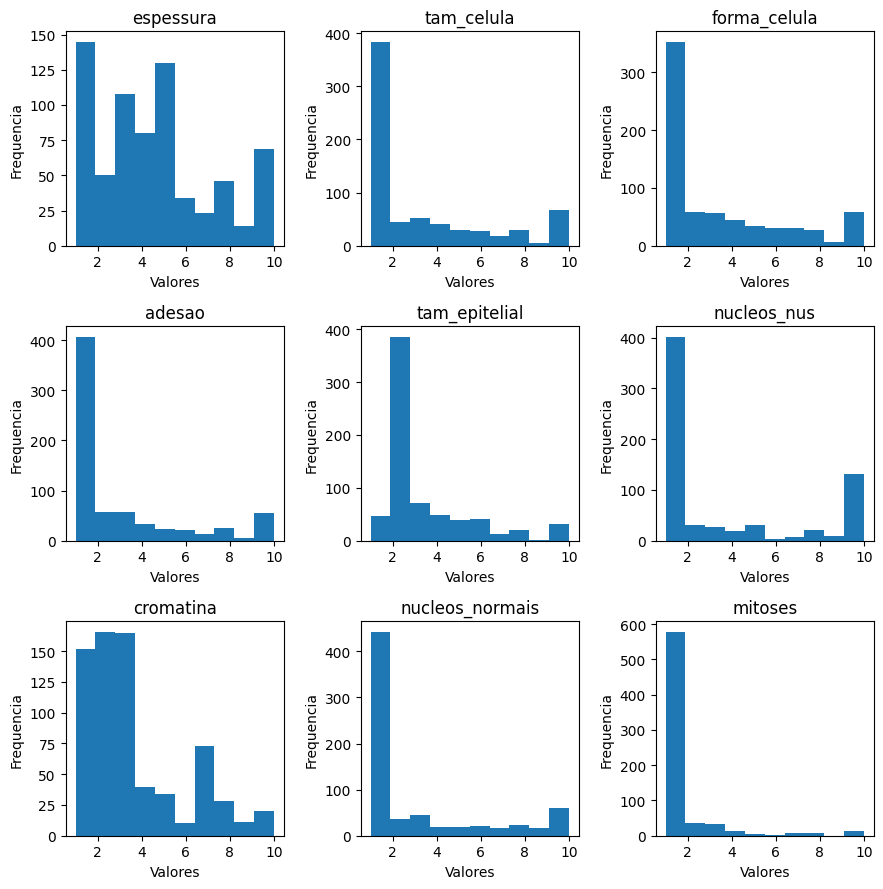

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(9,9), tight_layout=True)

for i, column in enumerate(x_names):
    row = i // 3 # linha atual 
    col = i % 3 # coluna atual 

    axs[row, col].hist(data[column], bins=10)
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Valores')
    axs[row, col].set_ylabel('Frequencia')
    
plt.show()
    

In [11]:
data.boxplot(column=x_names, by='diagnostico', figsize=(12,12))
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

### 4.2 Detecção de dados faltantes e Interpolação 


In [ ]:
# Detecção de dados faltantes 
missing_counts = data.isnull().sum()
print('Total de dados faltantes por atributo:')
print(missing_counts)

Total de dados faltantes por atributo:
espessura           0
tam_celula          0
forma_celula        0
adesao              0
tam_epitelial       0
nucleos_nus        16
cromatina           0
nucleos_normais     0
mitoses             0
diagnostico         0
dtype: int64


In [ ]:
#interpola os dados faltantes
def interpolacao(data):
    if data.isnull().values.any():
        points_inds_danger = [0, 1, len(data) - 2, len(data) - 1]
        for colname in x_names:
            for ind_danger in points_inds_danger:
                if np.isnan(data[colname].iloc[ind_danger].astype(float)):
                    data[colname].iloc[ind_danger] = data[colname].mean()
            data[colname] = data[colname].interpolate(method='nearest').copy()
    return data

In [ ]:
if interp_exec:
    data = interpolacao(data)

# verifica novamente os dados
missing_counts = data.isnull().sum()
print('Total de dados faltantes por atributo:')
print(missing_counts)

Total de dados faltantes por atributo:
espessura          0
tam_celula         0
forma_celula       0
adesao             0
tam_epitelial      0
nucleos_nus        0
cromatina          0
nucleos_normais    0
mitoses            0
diagnostico        0
dtype: int64


### 4.3 Detecção e substituição de outliers 

In [ ]:
def getQuantiles(x, margin = 1.5, low = 0.1, high = 0.9):
    q1 = x.quantile(low)
    q3 = x.quantile(high)
    iqr = q3 - q1
    fence_low = q1 - margin * iqr
    fence_high = q3 + margin * iqr
    return [fence_low, fence_high]

def replaceOutliers(serie, m):
    x = serie.copy()
    fences = getQuantiles(x, margin = m)
    bad_inds = x.loc[(x < fences[0]) | (x > fences[1])].index
    x[bad_inds] = np.nan
    outlier_inds_danger = [0, 1, len(serie) - 2, len(serie) - 1]
    for ind_danger in outlier_inds_danger:
        if np.isnan(x.iloc[ind_danger]):
            x[ind_danger] = (fences[0] + fences[1])/2
    if x.isnull().values.any():
        x = x.interpolate(method='nearest').copy()
    return x

In [ ]:
if outliers_exec:
    for col in x_names: 
        data[col] = replaceOutliers(data[col], 0)

### 4.4 Aplicando normalização (estabilização da variancia)

In [ ]:
def normalization(data, method):
    if method == 'asinh':
        return np.arcsinh(data)
    elif method == 'log':
        return np.log(data)
    else: 
        return (data - np.mean(data)) / np.std(data)

In [ ]:
if normalization_exec:
    for col in x_names:
        data[col] = normalization(data[col], 'mean')

data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,0.481973,-0.653930,-0.706788,-0.582619,-0.620341,-0.696275,0.026555,-0.544156,-0.331584,0.0
1,0.481973,0.728420,0.683582,1.497845,0.953592,1.781250,0.026555,-0.089717,-0.331584,0.0
2,-0.386324,-0.653930,-0.706788,-0.582619,-0.620341,-0.420994,0.026555,-0.544156,-0.331584,0.0
3,0.916122,2.571552,2.537408,-0.582619,0.166625,0.129567,0.026555,2.182474,-0.331584,0.0
4,0.047825,-0.653930,-0.706788,0.457613,-0.620341,-0.696275,0.026555,-0.544156,-0.331584,0.0
...,...,...,...,...,...,...,...,...,...,...
694,-0.386324,-0.653930,-0.706788,-0.582619,0.166625,-0.420994,-1.034124,-0.544156,-0.331584,0.0
695,-0.820473,-0.653930,-0.706788,-0.582619,-0.620341,-0.696275,-1.034124,-0.544156,-0.331584,0.0
696,0.481973,-0.653930,-0.706788,0.457613,-0.620341,-0.145714,-1.034124,-0.544156,1.683871,1.0
697,0.047825,2.571552,1.610495,0.977729,0.166625,0.129567,0.556894,1.728036,-0.331584,1.0


### 4.5 Aplicando escalonamento dos dados

In [ ]:
# funcao que cria uma regra com valores de min e max para usar no escalonamento 
def create_support_col(minvalue, maxvalue, sizecol):
    minvalue = [minvalue] * round(sizecol/2)
    maxvalue = [maxvalue] * (sizecol-round(sizecol/2))
    return [*minvalue, *maxvalue]

def minMaxIndividual(df, col, minvalue, maxvalue, rgint):
    serie = df[col].copy()

    # cria uma regra com um valor minimo e maxumo previamente determinado
    serie['support'] = create_support_col(minvalue, maxvalue, len(serie))

    # escalona considerando o minimo e maximo 
    tmp = serie.to_numpy().reshape(-1, 1)

    # cria objeto de escalonamento
    minmaxscaler = preprocessing.MinMaxScaler(feature_range=rgint).fit(tmp)

    # cria os dados escalonados
    scaled = minmaxscaler.transform(tmp).reshape(serie.shape[0], serie.shape[1])

    # remove a coluna de suporte e atualiza as escolanadas no dataset 
    df[col] = scaled[:,0:(scaled.shape[1]-1)]

    return df


In [ ]:
if scale_exec:
    scale_range = (0,1)
    for col in x_names:
        data = minMaxIndividual(data,[col], np.min(data[col]), np.max(data[col]), scale_range)

data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,0.500,0.000,0.000000,0.000000,0.00,0.000000,0.333333,0.000,0.0,0.0
1,0.500,0.375,0.428571,0.571429,0.50,1.000000,0.333333,0.125,0.0,0.0
2,0.250,0.000,0.000000,0.000000,0.00,0.111111,0.333333,0.000,0.0,0.0
3,0.625,0.875,1.000000,0.000000,0.25,0.333333,0.333333,0.750,0.0,0.0
4,0.375,0.000,0.000000,0.285714,0.00,0.000000,0.333333,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,0.250,0.000,0.000000,0.000000,0.25,0.111111,0.000000,0.000,0.0,0.0
695,0.125,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.0,0.0
696,0.500,0.000,0.000000,0.285714,0.00,0.222222,0.000000,0.000,0.5,1.0
697,0.375,0.875,0.714286,0.428571,0.25,0.333333,0.500000,0.625,0.0,1.0


In [ ]:
sumarizacao(data)

+-----------------+----------+----------+---------+-----------+-----------------+
| Coluna          |   Maximo |   Minimo |   Media |   Mediana |   Desvio Padrao |
+=================+==========+==========+=========+===========+=================+
| espessura       |        1 |        0 |    0.36 |      0.38 |            0.29 |
+-----------------+----------+----------+---------+-----------+-----------------+
| tam_celula      |        1 |        0 |    0.18 |      0    |            0.27 |
+-----------------+----------+----------+---------+-----------+-----------------+
| forma_celula    |        1 |        0 |    0.22 |      0    |            0.31 |
+-----------------+----------+----------+---------+-----------+-----------------+
| adesao          |        1 |        0 |    0.16 |      0    |            0.27 |
+-----------------+----------+----------+---------+-----------+-----------------+
| tam_epitelial   |        1 |        0 |    0.2  |      0    |            0.32 |
+---------------

### 4.6 Exportando ou carregando um dataset tratado

In [ ]:
if export_frames:
    bar = progressbar.ProgressBar(maxval=len(data), widgets=[progressbar.Bar("=", "[","]"), " ", progressbar.Percentage()])
    bar.start()
    x_frames = []
    y_frames = []
    cont = 0
    for ind in range(0, len(data), 1):
        x_frames.append(data.loc[ind, x_names].values)
        y_frames.append(data.loc[ind, y_names].values.reshape(-1))
        bar.update(cont + 1)
        cont += 1
    x_frames = np.array(x_frames)
    y_frames = np.array(y_frames).reshape(-1, 1)
    dump(x_frames, 'dataset/x_frames.joblib')
    dump(y_frames, 'dataset/y_frames.joblib')
    bar.finish()
else:
    x_frames = load('dataset/x_frames.joblib')
    y_frames = load('dataset/y_frames.joblib')
print(x_frames.shape)
print(y_frames.shape)

(699, 9)
(699, 1)


In [ ]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x_frames, y_frames, test_size=0.3, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, shuffle=True)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(391, 9)
(391, 1)
(98, 9)
(98, 1)
(210, 9)
(210, 1)


## 5. Treinamento do Modelo

### 5.1 Construção do Modelo

In [ ]:
#empilhamento de camadas para construcao da dnn
#parametros da rede
act_function = 'sigmoid'
drop = 0.1
initializer = tensorflow.keras.initializers.lecun_normal()
#camada de entrada
inputs = Input(shape = (x_train.shape[1],), dtype='float32')
#camada 1
layer1 = Dense(32, activation = act_function, kernel_initializer = initializer)(inputs)
layer1 = Dropout(drop)(layer1)

#camada 2
layer2 = Dense(64, activation = act_function, kernel_initializer = initializer)(layer1)
layer2 = Dropout(drop)(layer2)

#camada 3
layer3 = Dense(32, activation = act_function, kernel_initializer = initializer)(layer2)
layer3 = Dropout(drop)(layer3)

#camada de saida
outputs = Dense(y_train.shape[1], activation = act_function, kernel_initializer = initializer)(layer3)

#geracao do modelo
dnn_breast_cancer = Model(inputs, outputs)

### 5.2 Inspeção do Modelo 

In [ ]:
dnn_breast_cancer.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

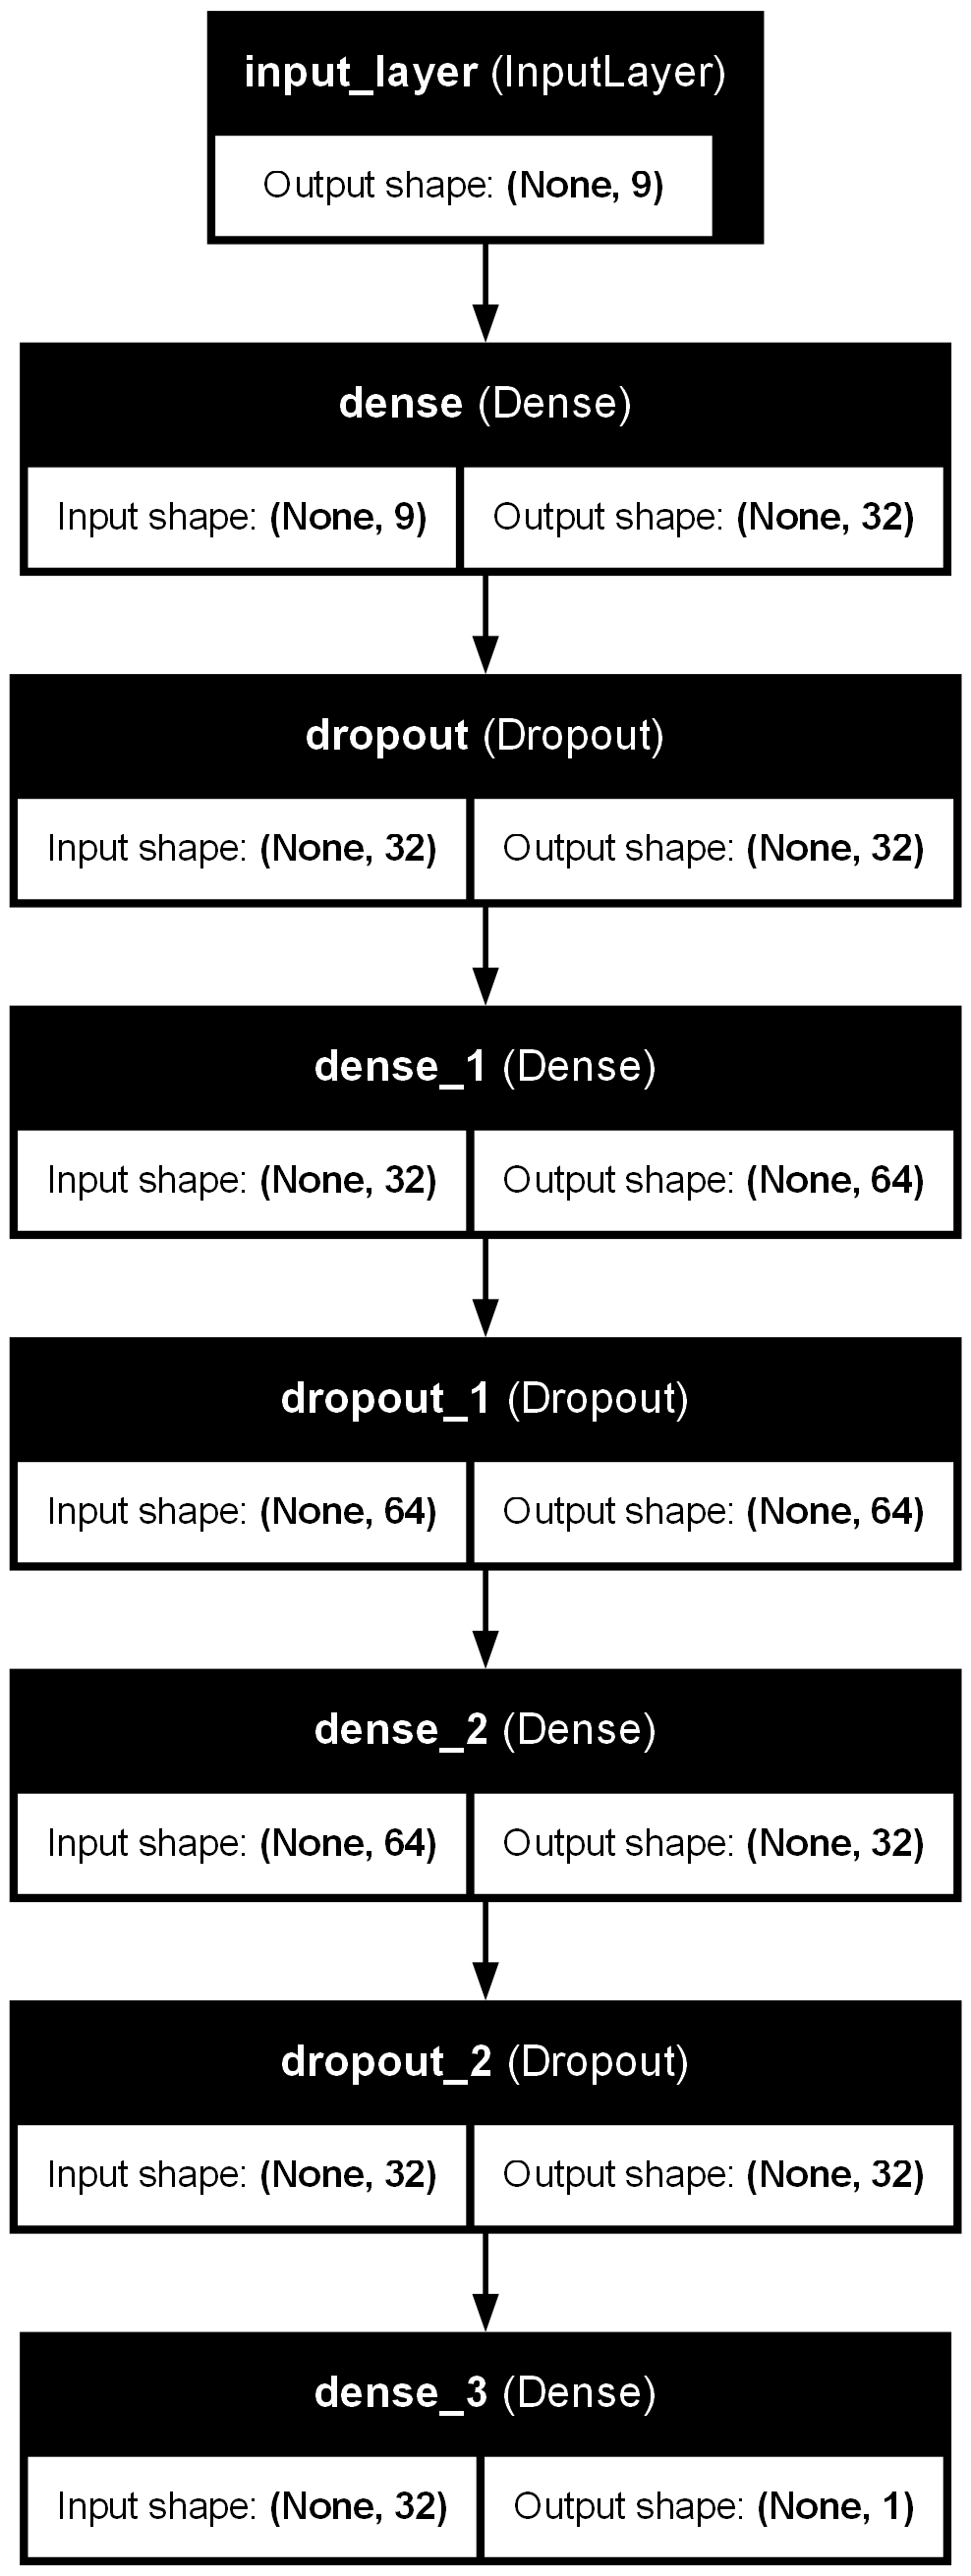

In [ ]:
plot_model(dnn_breast_cancer, show_shapes=True, show_layer_names=True, rankdir="TB")

### 5.3 Otimização do Modelo

In [ ]:
if (new_model):
    tensorflow.keras.backend.set_epsilon(1)
    opt = Adam(learning_rate = 0.0001)
    dnn_breast_cancer.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    cp = ModelCheckpoint(
        filepath = 'models/best_weights.weights.h5', 
        save_weights_only = True,
        monitor = 'loss',
        mode = 'min',
        save_best_only = True)
    es = EarlyStopping(monitor = 'loss', mode = 'min', patience = 100)
    history = dnn_breast_cancer.fit(
        x_train, y_train,
        validation_data = (x_val, y_val),
        epochs = 1000,
        verbose = 1,
        callbacks = [es, cp],
        batch_size = 8,
        shuffle = False)
    np.save('models/history_model.npy', history.history)
    dnn_breast_cancer.load_weights('models/best_weights.weights.h5')
    dnn_breast_cancer.save('models/dnn_breast_cancer.keras') 
else:
    dnn_breast_cancer = load_model('models/dnn_breast_cancer.keras')

Epoch 1/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3350 - loss: 0.8488 - val_accuracy: 0.3061 - val_loss: 0.8163
Epoch 2/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3529 - loss: 0.7770 - val_accuracy: 0.3061 - val_loss: 0.7501
Epoch 3/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3836 - loss: 0.7317 - val_accuracy: 0.3061 - val_loss: 0.7043
Epoch 4/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5422 - loss: 0.6888 - val_accuracy: 0.6939 - val_loss: 0.6740
Epoch 5/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6010 - loss: 0.6698 - val_accuracy: 0.6939 - val_loss: 0.6531
Epoch 6/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6445 - loss: 0.6546 - val_accuracy: 0.6939 - val_loss: 0.6403
Epoch 7/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6496 - loss: 0.6470 - val_accuracy: 0.6939 - val_loss: 0.6311
Epoch 8/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6547 - loss: 0.6522 - val_accuracy: 0

In [ ]:
pygame.mixer.init()
arquivo_mp3 = 'support_files/mario_coin.mp3'
pygame.mixer.music.load(arquivo_mp3)
pygame.mixer.music.play()
while pygame.mixer.music.get_busy():
    continue
print('Sucesso!')

Sucesso!


## 6. Avaliando a Qualidade do Treino 

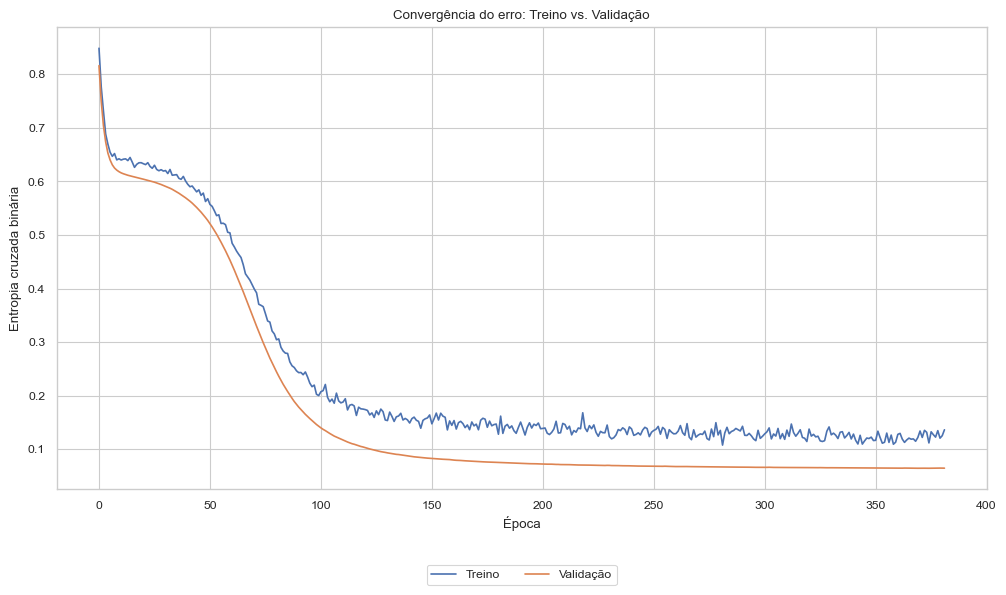

In [ ]:
history = np.load('models/history_model.npy', allow_pickle = True).item()
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')
train_metric = history['loss']
valid_metric = history['val_loss']
name_metric = 'Entropia cruzada binária'
fig = plt.figure()
plt.plot(train_metric, label = 'Treino')
plt.plot(valid_metric, label = 'Validação')
plt.ylabel(name_metric)
plt.xlabel('Época')
plt.title('Convergência do erro: Treino vs. Validação')
plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, shadow = False, ncol = 2)
plt.show()

## 7. Testando Previsões 

### 7.1 Gerando as previsões com o modelo treinado

In [ ]:
y_hat = dnn_breast_cancer.predict(x_test)
y_hat, y_test = (y_hat > 0.5, y_test > 0.5)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


### 7.2. Calculando a taxa de acerto com base na matriz de confusão

In [ ]:
#calcula a matriz de confusão
cm = confusion_matrix(y_test.tolist(), y_hat.tolist())
print(cm)

[[123   7]
 [  4  76]]


In [ ]:
#calcula a acuracia
accuracy = (cm[0,0] + cm[1,1])/cm.sum()
accuracy_percent = round(accuracy * 100, 2)
print("Taxa de Acerto: {:.2f}%".format(accuracy_percent))

Taxa de Acerto: 94.76%


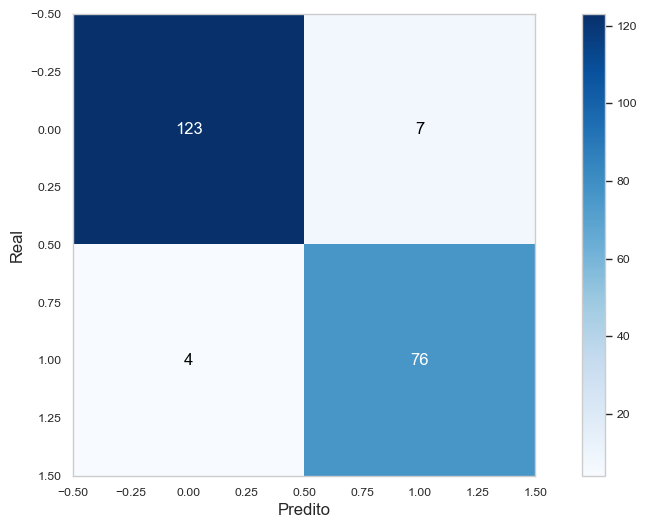

In [ ]:
#plot da matriz de confusao
plt.grid(False)
plt.imshow(cm, cmap = 'Blues')
plt.xlabel('Predito', fontsize = 12)
plt.ylabel('Real', fontsize = 12)
threshold = cm.max()/2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = 'white' if cm[i, j] > threshold else 'black'
        plt.text(j, i, str(cm[i, j]), ha = 'center', va = 'center', color = color, fontsize = 12)
plt.colorbar()
plt.show()

In [ ]:
#TESTE FINAL DE CLASSIFICAÇÃO
#selecionar pacientes aleatorios e fazer a previsão
indices_benignos = np.where(y_test == 0)[0]
indices_malignos = np.where(y_test == 1)[0]
#selecionar alguns
idx_benigno = np.random.choice(indices_benignos)
idx_maligno = np.random.choice(indices_malignos)
#selecionar um paciente
paciente_benigno = x_test[idx_benigno:idx_benigno + 1]
paciente_maligno = x_test[idx_maligno:idx_maligno + 1]
#fazer previsões
pred_benigno = dnn_breast_cancer.predict(paciente_benigno, verbose = 0)[0][0]
pred_maligno = dnn_breast_cancer.predict(paciente_maligno, verbose = 0)[0][0]
#pega o valor real para comparar com o predito
real_benigno = y_test[idx_benigno][0]
real_maligno = y_test[idx_maligno][0]
#classificação
classe_pred_benigno = 'maligno' if pred_benigno > 0.5 else 'benigno'
classe_pred_maligno = 'maligno' if pred_benigno > 0.5 else 'benigno'
#classificação dos previstos
acertou_benigno = (pred_benigno <= 0.5 and real_benigno == 0)
acertou_maligno = (pred_maligno > 0.5 and real_maligno == 1)
#exibir resultado
print('PACIENTE COM CÂNCER BENIGNO (real)')
print(f'Probabilidade prevista: {pred_benigno:.4f}')
print(f'Classificação prevista: {classe_pred_benigno}')
print(f'Resultado: {"acertou" if acertou_benigno else "errou"}')
print('='*60)
print('PACIENTE COM CÂNCER MALIGNO (real)')
print(f'Probabilidade prevista: {pred_maligno:.4f}')
print(f'Classificação prevista: {classe_pred_maligno}')
print(f'Resultado: {"acertou" if acertou_maligno else "errou"}')

PACIENTE COM CÂNCER BENIGNO (real)
Probabilidade prevista: 0.0051
Classificação prevista: benigno
Resultado: acertou
PACIENTE COM CÂNCER MALIGNO (real)
Probabilidade prevista: 0.9688
Classificação prevista: benigno
Resultado: acertou
